In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os

import GPy

In [46]:
os.chdir('/home/saumya/Documents/Spec_data/')

In [47]:
x_dat = np.load('abs.npy').astype(np.half)

x_dat = x_dat[:100]

In [48]:
y_dat = np.load('temp.npy')

y_dat = np.reshape(y_dat, -1)[:, None]

y_dat = y_dat[:100]

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [51]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

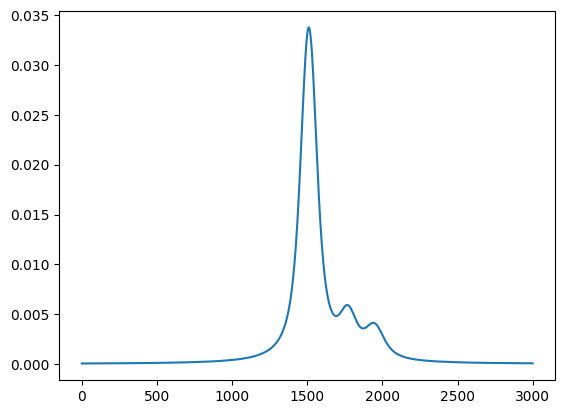

In [52]:
plt.plot(x_dat[50])

In [60]:
print(y_dat[50])

[1503.50035004]


In [53]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(X_train)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(X_train)[1],num_outputs=1,kernel=ks)

In [54]:
print(icm)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)

  ICM.             |        value  |  constraints  |  priors
  rbf.variance     |          1.0  |      +ve      |        
  rbf.lengthscale  |          1.0  |      +ve      |        
  B.W              |  [0.4692287]  |               |        
  B.kappa          |          0.5  |      +ve      |        
W matrix
   index  |    ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.46922870  |               |        

kappa vector
   index  |  ICM.B.kappa  |  constraints  |  priors
  [0]    |   0.50000000  |      +ve      |        

B matrix
 [[0.72017557]]


In [55]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 1542491.054498557
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |        value  |  constraints  |  priors
  ICM.rbf.variance                       |          1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |          1.0  |      +ve      |        
  ICM.B.W                                |  [0.4692287]  |               |        
  ICM.B.kappa                            |          0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |          1.0  |      +ve      |        


In [56]:
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)

W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.46922870  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        


In [57]:
m.optimize()

In [58]:
print(m)
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 35.26407372281493
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                    value  |  constraints  |  priors
  ICM.rbf.variance                       |                      1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |        1.041645485709489  |      +ve      |        
  ICM.B.W                                |           [1504.9193119]  |               |        
  ICM.B.kappa                            |  1.7494293299965035e-145  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |      0.09375303048142786  |      +ve      |        
W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  1504.91931190  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.00000000  |      +ve      |        

B matrix
 [[2264782.13532595]]


In [59]:
m.predict(X_test)

IndexError: index 3000 is out of bounds for axis 1 with size 3000